In [1]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple
# Для визуализации
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from IPython import display
import glob

In [2]:
# Создание окружения.
env = gym.make('BipedalWalker-v3', render_mode='rgb_array')
obs, info = env.reset(seed=0)
"""
    1.  hull_angle             - угол наклона корпуса  
    2.  hull_angular_velocity  - угловая скорость корпуса  
    3.  hull_x_velocity        - горизонтальная скорость корпуса  
    4.  hull_y_velocity        - вертикальная скорость корпуса  
    5.  hip_1_joint_angle      - угол в первом бедре (левая нога)  
    6.  hip_1_joint_speed      - скорость в первом бедре  
    7.  knee_1_joint_angle     - угол в первом колене  
    8.  knee_1_joint_speed     - скорость в первом колене  
    9.  foot_1_contact         - есть ли контакт первой (левой) стопы с землей  
    10. hip_2_joint_angle      - угол во втором бедре (правая нога)  
    11. hip_2_joint_speed      - скорость во втором бедре  
    12. knee_2_joint_angle     - угол во втором колене  
    13. knee_2_joint_speed     - скорость во втором колене  
    14. foot_2_contact         - есть ли контакт второй (правой) стопы с землей  
    15. lidar_1                - дистанция до земли по первому лучу (вниз)  
    16. lidar_2                - дистанция до земли по второму лучу  
    17. lidar_3                - дистанция до земли по третьему лучу  
    18. lidar_4                - дистанция до земли по четвертому лучу  
    19. lidar_5                - дистанция до земли по пятому лучу  
    20. lidar_6                - дистанция до земли по шестому лучу  
    21. lidar_7                - дистанция до земли по седьмому лучу  
    22. lidar_8                - дистанция до земли по восьмому лучу  
    23. lidar_9                - дистанция до земли по девятому лучу
    24. lidar_10               - дистанция до земли по десятому лучу  
    
"""
print('State shape: ', env.observation_space.shape)
""" 
    Действия для 4 моторов:
    1. hip_left - мотор левого бедра (вращение вперед/назад)
    2. knee_left - мотор левого колена (сгибание/разгибание)
    3. hip_right - мотор правого бедра (вращение вперед/назад)
    4. knee-right - мотор правого колена (сгибание/разгибание)
"""
print('Action space shape: ', env.action_space.shape)

State shape:  (24,)
Action space shape:  (4,)


In [3]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print(state_size)
print(action_size)

24
4


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Класс, добавляющий смещение (bias) к входным данным.
class AddBias(nn.Module):
    def __init__(self, bias):
        """ Используется для параметризации логарифма стандартного отклонения (logstd) в распределении.
            Параметры
            =========
            bias — это вектор параметров, который будет обучаться.
        """
        super(AddBias, self).__init__()
        # unsqueeze(1) добавляет размерность, чтобы bias был параметром в форме (N,1) для удобства.
        self._bias = nn.Parameter(bias.unsqueeze(1))
    
    def forward(self, x):
        # self._bias имеет форму (N,1), транспонируем и меняем форму на (1, N)
        bias = self._bias.t().view(1, -1)
        # Прибавляем bias к входному тензору x.
        # Это сдвиг каждого элемента по соответствующему каналу.
        return x + bias

In [6]:
# Класс расширяет стандартное нормальное распределение PyTorch: mean=0, std=1.
# Добавляет суммирование логарифмов вероятностей по последней размерности (для многомерных действий),
# а также суммирование энтропии по последней размерности.
# И добавляет метод mode — возвращает среднее значение, как детерминированное действие.
class FixedNormal(torch.distributions.Normal):
    # Возвращает сумму логарифмов плотностей вероятности для всех размерностей (например, для всех действий).
    def log_probs(self, x):
        # super().log_prob(x) возвращает логарифм вероятности для каждого элемента,
        # sum(-1) суммирует по последней размерности (например, по вектору действия).
        return super().log_prob(x).sum(-1)
    
    # Возвращает сумму энтропии по последней размерности.
    # Энтропия — мера неопределенности распределения.
    def entropy(self):
        return super().entropy().sum(-1)

    # Режим (mode) распределения — это его среднее значение.
    # Используется для детерминированного выбора действия.
    def mode(self):
        return self.mean

In [7]:
# Диагональное гауссовское распределение (с независимыми компонентами) для многомерного действия.
# Принимает на вход фичи (embedding) из нейросети и выдаёт нормальное распределение с параметрами:
# среднее (mean) и логарифм стандартного отклонения (logstd).
class DiagGaussian(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(DiagGaussian, self).__init__()
        # Линейный слой, который преобразует входной вектор (фичи) в средние значения для каждой компоненты действия.
        # Формально: mean = W * x + b, где W — матрица весов, x — входные признаки, b — смещение.
        self.fc_mean = nn.Linear(inp_dim, out_dim)
        
        # Логарифм стандартного отклонения параметризуется отдельно как обучаемый вектор смещений.
        # Изначально все элементы логстд равны нулю, т.е. std = exp(0) = 1.
        # Используем AddBias, чтобы иметь независимые параметры logstd для каждого измерения действия.
        self.b_logstd = AddBias(torch.zeros(out_dim))
    
    def forward(self, x):
        # Вычисляем среднее значение нормального распределения.
        mean = self.fc_mean(x)
        
        # Создаем тензор с нулями той же формы, что и mean,
        # и добавляем к нему обучаемое смещение logstd с помощью AddBias.
        # logstd — это логарифм стандартного отклонения.
        logstd = self.b_logstd(torch.zeros_like(mean))
        
        # Возвращаем объект FixedNormal, который представляет многомерное нормальное распределение
        # с векторами mean и std = exp(logstd) (поэлементно).
        # Формула для каждого измерения i: X_i ~ Normal(mean_i, std_i), где std_i = exp(logstd_i).
        return FixedNormal(mean, logstd.exp())

In [8]:
# Актор-сеть (Policy Network) - вычисление распределения и выбор действия.
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """ Инициализируем актора.
            Параметры
            =========
            state_size (int): число состояний (их 24)
            action_size (int): число действий (их 4)
            seed (int): зерно случайности, 0 - означает отсуствие случайности.
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.dist = DiagGaussian(128, action_size)

    def forward(self, state, deterministic=False):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # Получаем распределение действий.
        dist = self.dist(x)

        if deterministic:
            action = dist.mode()   # нужен в случае запуска модели для тестирования
        else:
            action = dist.sample() # сэмплирование из распределения
        
        # Помимо действия, которое было сэмплировано (выбрано случайно),
        # я возвращаю еще логарифм вероятности этого действия - для обучения.
        return action, dist.log_probs(action)

    # Метод просто возвращает сэмплированное действие.
    def choose_action(self, state, deterministic=False):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        dist = self.dist(x)

        if deterministic:
            return dist.mode()
        
        return dist.sample()

    # Метод производит оценку действия, возвращая логарифм вероятности и энтропию, чтобы
    # посчитать энтропийный бонус и функцию потерь при обучении.
    def evaluate(self, state, action):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        dist = self.dist(x)
        return dist.log_probs(action), dist.entropy()

In [9]:
# Критик-сеть (Value Network) - оценка значения состояния V(s).
class Critic(nn.Module):
    def __init__(self, state_size, seed):
        """ Инициализируем актора.
            Параметры
            =========
            state_size (int): число состояний (их 24)
            seed (int): зерно случайности, 0 - означает отсуствие случайности.
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # Возвращаем одномерный тензор (batch_size,).
        return self.fc3(x).squeeze(-1)

In [10]:
# Класс, запускающий среду и собирающий батч опыта (rollout). Модификация ReplayBuffer - онлайновые rollout буффер.
class EnvRunner:
    def __init__(self, state_size, action_size, gamma=0.99, lamb=0.95, max_step=2048):
        """ Инициализация объекта EnvRunner.
            Параметры
            =========
            - state_size: размер вектора состояния среды (например, 24 для BipedalWalker).
            - action_size: размер вектора действия (например, 4).
            - gamma: коэффициент дисконтирования γ.
            - lamb: параметр λ для Generalized Advantage Estimation (GAE).
            - max_step: количество шагов в одном rollout (эпизоде).
        """
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lamb = lamb
        self.max_step = max_step
        self.device = device

        # Буферы для хранения данных rollout.
        # mb - mini-batch, просто префикс.
        """
            - mb_states: состояния
            - mb_actions: действия
            - mb_values: предсказанные value-состояния
            - mb_rewards: сырые награды
            - mb_a_logps: логарифмы вероятностей выбранных действий
        """
        self.mb_states = np.zeros((self.max_step, self.state_size), dtype=np.float32)
        self.mb_actions = np.zeros((self.max_step, self.action_size), dtype=np.float32)
        self.mb_values = np.zeros((self.max_step,), dtype=np.float32)
        self.mb_rewards = np.zeros((self.max_step,), dtype=np.float32)
        self.mb_a_logps = np.zeros((self.max_step,), dtype=np.float32)
    
    def compute_discounted_return(self, rewards, last_value):
        """
            Вычисляет дисконтированное суммарное вознаграждение (return):
            R_t = r_t + γ * r_{t+1} + γ^2 * r_{t+2} + ... + γ^n * V(s_{t+n})
        """
        returns = np.zeros_like(rewards)
        n_step = len(rewards)

        for t in reversed(range(n_step)):
            if t == n_step - 1:
                returns[t] = rewards[t] + self.gamma * last_value
            else:
                returns[t] = rewards[t] + self.gamma * returns[t+1]

        return returns
    
    def compute_gae(self, rewards, values, last_value):
        """
            Вычисляет обобщённую оценку преимущества (GAE).
            GAE помогает снизить дисперсию оценки A_t = Q(s,a) - V(s).
        """
        advs = np.zeros_like(rewards)
        n_step = len(rewards)
        last_gae_lam = 0.0

        for t in reversed(range(n_step)):
            if t == n_step - 1:
                next_value = last_value
            else:
                next_value = values[t+1]

            delta = rewards[t] + self.gamma*next_value - values[t]
            advs[t] = last_gae_lam = delta + self.gamma*self.lamb*last_gae_lam

        # Возвращаем Advantage + Value → GAE Return.
        return advs + values

    def run(self, env, policy_net, value_net):
        """
            Один rollout (эпизод) взаимодействия с окружающей средой:
            собирает состояния, действия, значения, лог-вероятности и награды.
    
            Возвращает:
            - mb_states: состояния
            - mb_actions: действия
            - mb_a_logps: логарифмы вероятностей выбранных действий
            - mb_values: предсказанные value-состояния
            - mb_returns: цели для value-функции (GAE или дисконтированные returns)
            - mb_rewards: сырые награды
        """
        state, _ = env.reset()
        episode_len = self.max_step

        for step in range(self.max_step):
            # Преобразуем состояние в тензор.
            state_tensor = torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=self.device)
            # Получаем действие, лог-вероятность и value.
            action, a_logp = policy_net(state_tensor)
            value = value_net(state_tensor)

            # Переносим все в numpy.
            action = action.cpu().numpy()[0]
            a_logp = a_logp.cpu().numpy()
            value  = value.cpu().numpy()

            # Сохраняем в буферы.
            self.mb_states[step] = state
            self.mb_actions[step] = action
            self.mb_a_logps[step] = a_logp.item()
            self.mb_values[step] = value.item()

            # Шаг среды.
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            self.mb_rewards[step] = reward

            if done:
                episode_len = step + 1
                break
        
        # Получаем значение последнего состояния (bootstrap для GAE / returns).
        last_value = value_net(torch.tensor(np.expand_dims(state, axis=0), dtype=torch.float32, device=self.device)).cpu().numpy().item()

        # Вычисляем returns: можно выбрать между GAE и простой дисконтированной суммой.
        mb_returns = self.compute_discounted_return(self.mb_rewards[:episode_len], last_value)
        # mb_returns = self.compute_gae(self.mb_rewards[:episode_len], self.mb_values[:episode_len], last_value)
        
        return ( self.mb_states[:episode_len],
                 self.mb_actions[:episode_len],
                 self.mb_a_logps[:episode_len],
                 self.mb_values[:episode_len],
                 mb_returns,
                 self.mb_rewards[:episode_len]
            )
     


In [11]:
# Класс PPOAgent реализует обучение агента с использованием алгоритма Proximal Policy Optimization.
class PPOAgent:
    def __init__(self, actor, critic, lr=1e-4, max_grad_norm=0.5, ent_weight=0.01,
                 clip_val=0.2, sample_n_epoch=4, sample_mb_size=64):
        """
            Параметры
            =========
            actor	       : cеть политики (π), выбирающая действия по состоянию
            critic	       : ценностная сеть (V), оценивающая состояние
            lr	           : скорость обучения (Learning Rate)
            max_grad_norm  : максимальное значение нормы градиента для стабилизации
            ent_weight	   : вес энтропийного бонуса — для увеличения разнообразия действий
            clip_val	   : параметр ε для PPO-клипа (обрезания границ при обновлении политики)
            sample_n_epoch : сколько раз проходить по одному и тому же rollout (эпизоду)
            sample_mb_size : размер одного minibatch’а (батча)
        """
        self.actor = actor.to(device)
        self.critic = critic.to(device)

        self.max_grad_norm = max_grad_norm
        self.ent_weight = ent_weight
        self.clip_val = clip_val
        self.sample_n_epoch = sample_n_epoch
        self.sample_mb_size = sample_mb_size

        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr)

    def train(self, mb_states, mb_actions, mb_old_values, mb_advs, mb_returns, mb_old_a_logps):
        """
            Метод train реализует ядро PPO-обновления:
            - Он принимает батчи данных, собранных во время прохождения среды (rollout).
            - Обучает actor и critic по этим батчам с использованием формул PPO.

            Параметры
            =========
            mb_states	   : состояния среды за эпизод
            mb_actions	   : действия, выбранные агентом
            mb_old_values  : значения V(s) до обновления
            mb_advs	       : преимущества (advantage estimates)
            mb_returns	   : возвраты (targets для критика)
            mb_old_a_logps : логарифмы вероятностей действий по старой политике
        """
        # Переводим в тензоры.
        mb_states = torch.from_numpy(mb_states).float().to(device)
        mb_actions = torch.from_numpy(mb_actions).float().to(device)
        mb_old_values = torch.from_numpy(mb_old_values).float().to(device)
        mb_advs = torch.from_numpy(mb_advs).float().to(device)
        mb_returns = torch.from_numpy(mb_returns).float().to(device)
        mb_old_a_logps = torch.from_numpy(mb_old_a_logps).float().to(device)

        # Корректное разбиние на мини-батчи накопленных примеров эпизода.
        episode_length = len(mb_states)
        rand_idx = np.arange(episode_length)
        sample_n_mb = episode_length // self.sample_mb_size
        
        if sample_n_mb <= 0:
            sample_mb_size = episode_length
            sample_n_mb = 1
        else:
            sample_mb_size = self.sample_mb_size

        for _ in range(self.sample_n_epoch):
            np.random.shuffle(rand_idx)
            for j in range(sample_n_mb):
                idx = rand_idx[j * sample_mb_size: (j + 1) * sample_mb_size]

                states = mb_states[idx]
                actions = mb_actions[idx]
                old_values = mb_old_values[idx]
                advantages = mb_advs[idx]
                returns = mb_returns[idx]
                old_logps = mb_old_a_logps[idx]

                new_logps, entropy = self.actor.evaluate(states, actions)
                values = self.critic(states)
                entropy = entropy.mean()

                # Value loss с clipping'ом.
                v_pred_clip = old_values + torch.clamp(values - old_values, -self.clip_val, self.clip_val)
                v_loss1 = (returns - values).pow(2)
                v_loss2 = (returns - v_pred_clip).pow(2)
                value_loss = torch.max(v_loss1, v_loss2).mean()

                # Policy loss (PPO clipped).
                ratio = (new_logps - old_logps).exp()
                pg_loss1 = -advantages * ratio
                pg_loss2 = -advantages * torch.clamp(ratio, 1.0 - self.clip_val, 1.0 + self.clip_val)
                policy_loss = torch.max(pg_loss1, pg_loss2).mean() - self.ent_weight * entropy

                # Обновляем actor.
                self.optimizer_actor.zero_grad()
                policy_loss.backward()
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.optimizer_actor.step()

                # Обновляем critic.
                self.optimizer_critic.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.optimizer_critic.step()

        return policy_loss.item(), value_loss.item(), entropy.item()


In [12]:
# Функция для запуска обученной модели, просто тестирование и сохранение видео-теста.
def play(policy_net, env_name='BipedalWalker-v3', video_path="video", filename="rl-video"):
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=video_path, name_prefix=filename, episode_trigger=lambda x: True)

    obs, _ = env.reset()
    total_reward = 0
    step_count = 0
    done = False

    with torch.no_grad():
        while not done:
            state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy_net.choose_action(state_tensor, deterministic=True)
            action = action.cpu().numpy()[0]

            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward
            step_count += 1

    env.close()
    print(f"[Evaluation] Total reward = {total_reward:.2f}, steps = {step_count}")

In [13]:
# Функция для вывода видео внутри блокнота.
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [14]:
def ppo(env, runner, policy_net, value_net, agent, max_episode=20000, target_score=300, target_max_step=1600, save_path="model.pt"):
    """
        Запускает алгоритм PPO.

        Парамтеры
        =========
        env	            : среда Gym (например, BipedalWalker-v3)
        runner	        : объект для запуска эпизодов и сбора данных (состояния, действия и т.д.)
        policy_net	    : нейронная сеть политики (actor)
        value_net	    : нейронная сеть критика (value function)
        agent	        : PPO агент — реализует обучение на основе собранных данных
        max_episode	    : максимальное количество эпизодов обучения (по умолчанию 5000)
        target_score	: целевая средняя награда для решения задачи
        target_max_step	: максимальное число шагов в эпизоде для успешного решения задачи
    """
    scores_window = deque(maxlen=100)  # последние 100 наград
    scores = []
    mean_total_reward = 0
    mean_length = 0

    for i in range(1, max_episode + 1):
        # Собираем опыт.
        with torch.no_grad():
            mb_states, mb_actions, mb_old_a_logps, mb_values, mb_returns, mb_rewards = runner.run(env, policy_net, value_net)
            mb_advs = mb_returns - mb_values
            # нормализация
            mb_advs = (mb_advs - mb_advs.mean()) / (mb_advs.std() + 1e-6)

        # Обучаем агента.
        pg_loss, v_loss, ent = agent.train(mb_states, mb_actions, mb_values, mb_advs, mb_returns, mb_old_a_logps)
        episode_reward = mb_rewards.sum()
        episode_length = len(mb_states)

        scores.append(episode_reward)
        scores_window.append(episode_reward)
        mean_total_reward += episode_reward
        mean_length += episode_length

        # Периодически сохраняем модель и воспроизводим видео
        if i % 100 == 0 and i > 0:
            print(f"\n[{i:5d} / {max_episode:5d}]")
            print("----------------------------------")
            print(f"actor loss = {pg_loss:.6f}")
            print(f"critic loss = {v_loss:.6f}")
            print(f"entropy = {ent:.6f}")
            print(f"mean return = {mean_total_reward / 100:.6f}")
            print(f"mean length = {mean_length / 100:.2f}")
            print("\nSaving the model ... ", end="")

            try:
                torch.save({
                    "it": i,
                    "PolicyNet": policy_net.state_dict(),
                    "ValueNet": value_net.state_dict()
                }, save_path)
                print("Done.\n")
            except Exception as e:
                print(f"Failed to save model: {e}\n")

            # Текущее обучение агента, видео и название.
            #play(policy_net, filename=f"ppo-step-{i}")
            #show_video("BipedalWalker-v3")

            mean_total_reward = 0
            mean_length = 0
        
        # Проверка условия решения задачи.
        if np.mean(scores_window) >= target_score and episode_length <= target_max_step:
            print(f"\nEnvironment solved in {i - 100} episodes! Average Score: {np.mean(scores_window):.2f}")
            torch.save(policy_net.state_dict(), "ppo_actor.pth")
            torch.save(value_net.state_dict(), "ppo_critic.pth")
            print("Final model saved.")
            play(policy_net, filename="ppo-success")
            show_video("BipedalWalker-v3")
            break

    return scores

In [15]:
policy_net = Actor(state_size, action_size, seed=0)
value_net = Critic(state_size, seed=0)
print(policy_net)
print(value_net)

Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (dist): DiagGaussian(
    (fc_mean): Linear(in_features=128, out_features=4, bias=True)
    (b_logstd): AddBias()
  )
)
Critic(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [16]:
runner = EnvRunner(state_size, action_size)

In [17]:
agent = PPOAgent(policy_net, value_net)
scores = ppo(env, runner, policy_net, value_net, agent)


[  100 / 20000]
----------------------------------
actor loss = 0.062430
critic loss = 0.557941
entropy = 5.660180
mean return = -105.087784
mean length = 558.65

Saving the model ... Done.


[  200 / 20000]
----------------------------------
actor loss = -0.052285
critic loss = 0.940354
entropy = 5.656362
mean return = -95.177452
mean length = 932.40

Saving the model ... Done.


[  300 / 20000]
----------------------------------
actor loss = -0.061947
critic loss = 5704.086426
entropy = 5.623454
mean return = -72.831551
mean length = 740.32

Saving the model ... Done.


[  400 / 20000]
----------------------------------
actor loss = -0.069914
critic loss = 4452.304688
entropy = 5.626145
mean return = -96.372498
mean length = 218.77

Saving the model ... Done.


[  500 / 20000]
----------------------------------
actor loss = -0.075288
critic loss = 595.517883
entropy = 5.664042
mean return = -74.336159
mean length = 584.70

Saving the model ... Done.


[  600 / 20000]
---------------

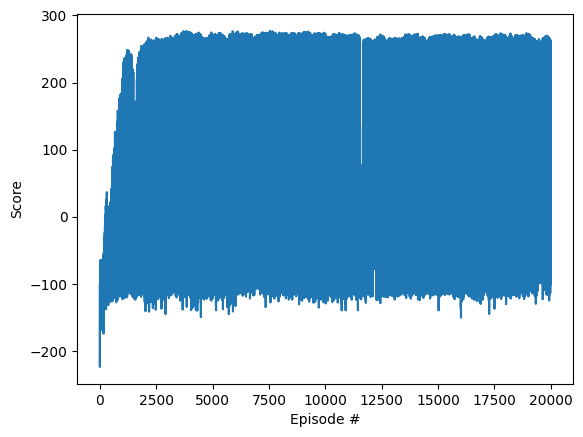

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
# Загрузка модели
checkpoint = torch.load("model.pt", map_location=torch.device("cpu"))
policy_net.load_state_dict(checkpoint["PolicyNet"])
value_net.load_state_dict(checkpoint["ValueNet"])
it = checkpoint.get("it", "неизвестно")
print("Модель загружена с эпизода:", it)

Модель загружена с эпизода: 20000


In [30]:
play(policy_net, filename=f"ppo-step-{it}")

[Evaluation] Total reward = 267.52, steps = 860


In [31]:
show_video("BipedalWalker-v3")